In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import sys
sys.path.append('../../')

In [16]:
import numpy as np
import torch
import fastai as fai
import fastai.vision as faiv
import fastai.callbacks as faic
import data.load

In [3]:
gpu_id = 3
num_cores = 4

In [4]:
faiv.torch.cuda.set_device(gpu_id)

In [5]:
nb_name = 'toy_critic_1'
path = faiv.Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/')
data_pth = path/'training/trainsets/'
model_pth = path/'models/critics/'

In [6]:
model_pth

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics')

## Data loading

In [7]:
# Image augmentations
tfms = faiv.get_transforms()

In [8]:
# Confirm data path
data_pth

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets')

In [9]:
# Create databunch
db = (faiv.ImageList.from_folder(data_pth)
      .filter_by_folder(['hr', 'pssr', 'bilinear', 'svd_30_40'])
      .split_by_rand_pct()
      .label_from_folder()
      .transform(size=256, resize_method=faiv.ResizeMethod.CROP)
      .databunch(num_workers=num_cores, bs=32)
      .normalize(faiv.imagenet_stats))

In [10]:
db.classes

['bilinear', 'hr', 'pssr', 'svd_30_40']

In [11]:
# Dataset sizes
len(db.train_ds), len(db.valid_ds)

(319991, 79997)

In [12]:
# Batch size and number of batches
db.batch_size, len(db.train_dl)

(32, 9999)

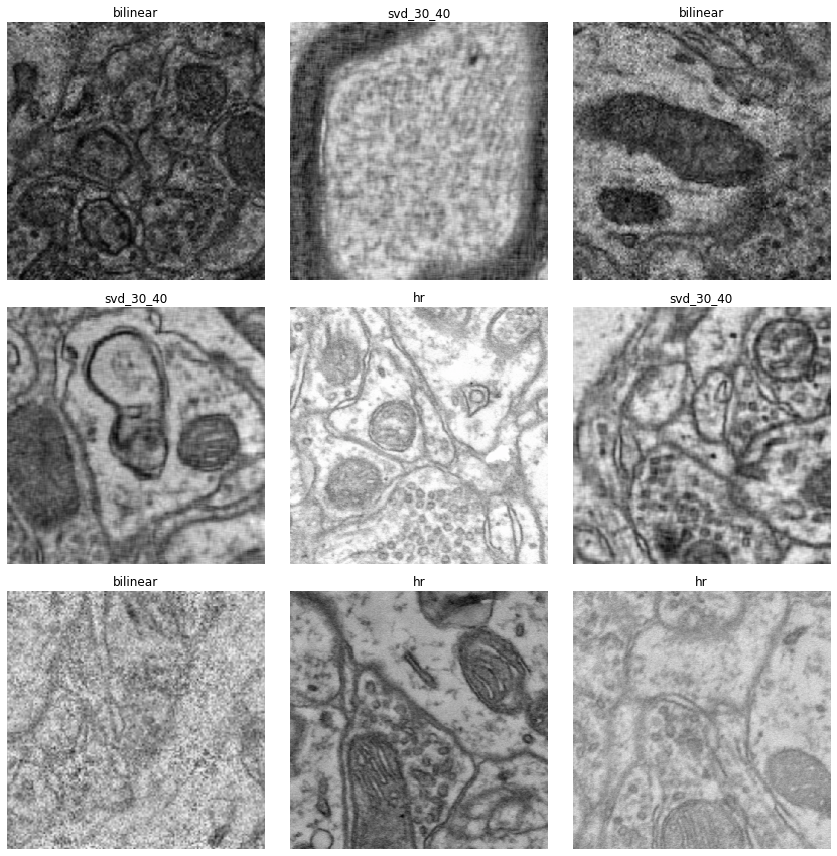

In [13]:
# Data Visualization
db.show_batch(rows=3)

## Data Subsample

In [22]:
db = data.load.subsample(db)

In [23]:
db.classes

['bilinear', 'hr', 'pssr', 'svd_30_40']

In [24]:
# Dataset sizes
len(db.train_dl), len(db.valid_dl)

(999, 250)

In [25]:
# Batch size and number of batches
db.batch_size

32

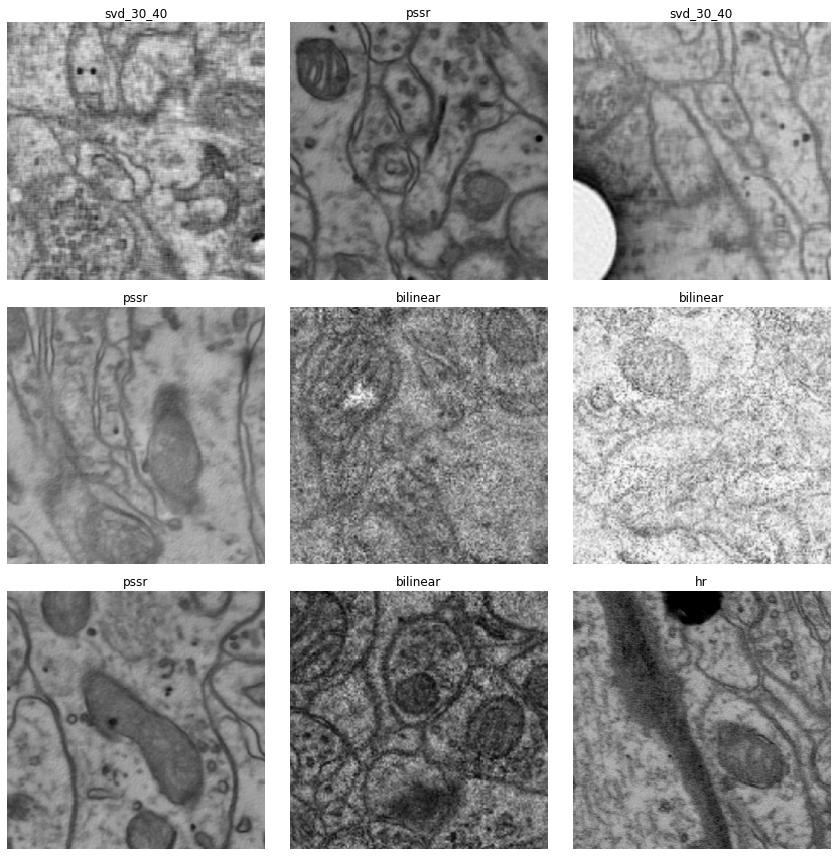

In [26]:
# Data Visualization
db.show_batch(rows=3)

# Model

## Initial Training

In [27]:
learn = faiv.cnn_learner(db, faiv.models.resnet34, metrics=faiv.error_rate)

In [28]:
learn.model_dir = model_pth

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


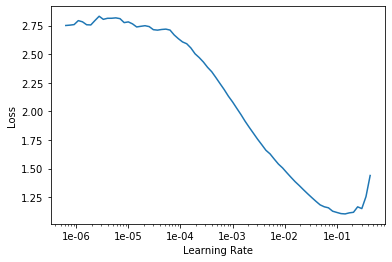

In [30]:
learn.recorder.plot()

In [31]:
lr = 1e-3
learn.fit_one_cycle(2, max_lr=lr)

In [32]:
learn.save("stage-1a")

In [35]:
interp = faiv.ClassificationInterpretation.from_learner(learn)

In [36]:
faiv.doc(interp.plot_top_losses)

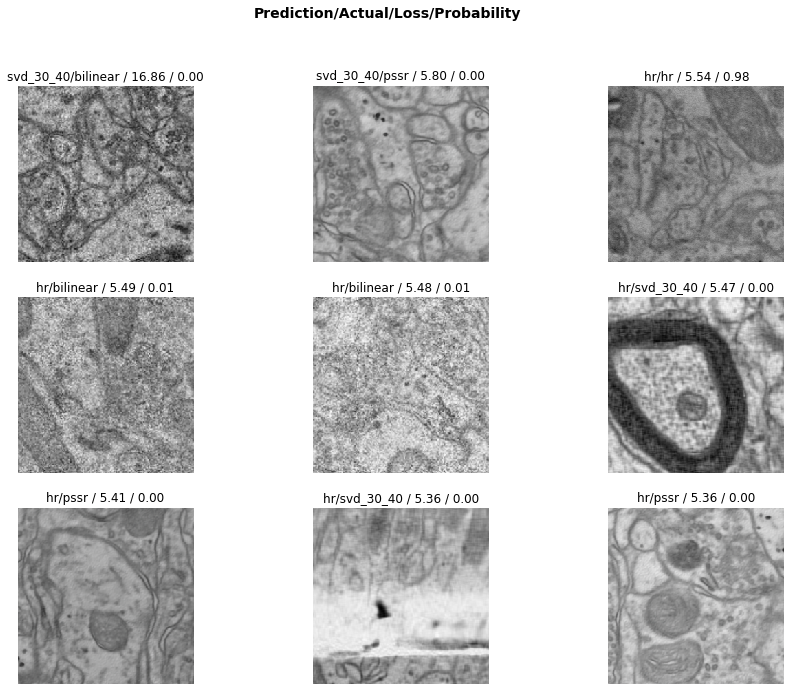

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

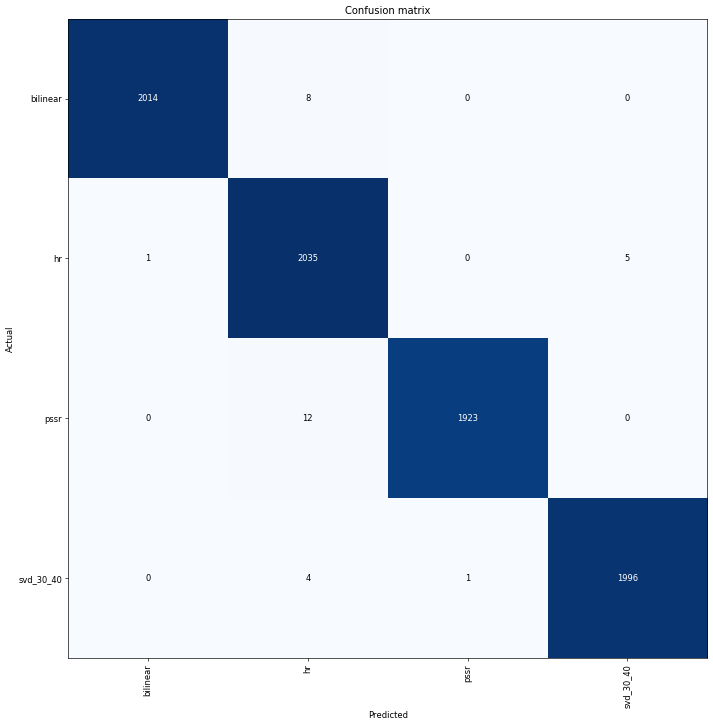

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [39]:
interp.most_confused(min_val=2)

[('pssr', 'hr', 12),
 ('bilinear', 'hr', 8),
 ('hr', 'svd_30_40', 5),
 ('svd_30_40', 'hr', 4)]

## Fine-tuning

In [46]:
learn.load('stage-1a');

Learner(data=ImageDataBunch;

Train: LabelList (319991 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
pssr,pssr,pssr,pssr,pssr
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets;

Valid: LabelList (79997 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
pssr,bilinear,svd_30_40,bilinear,bilinear
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [47]:
learn.unfreeze()

In [53]:
learn.fit_one_cycle(1, 3e-4)

In [54]:
interp = faiv.ClassificationInterpretation.from_learner(learn)

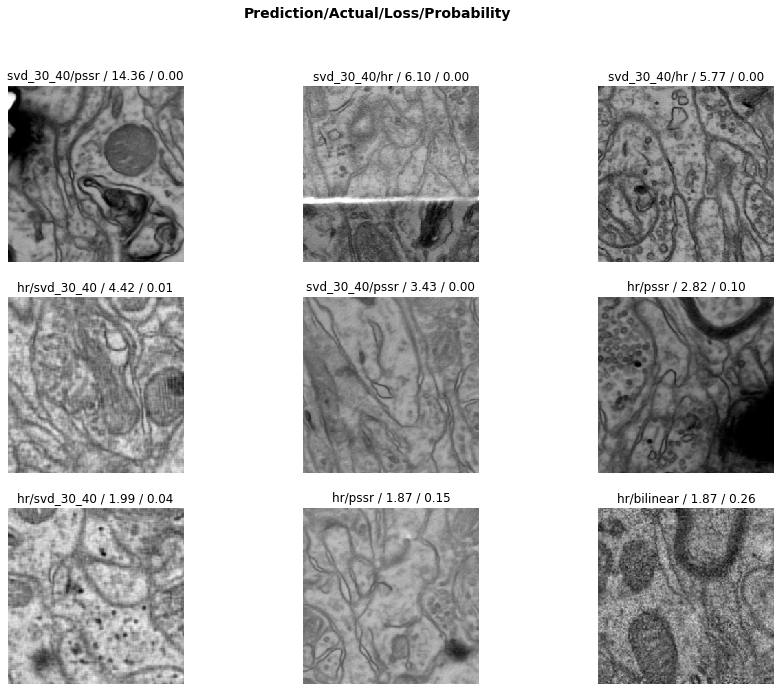

In [57]:
interp.plot_top_losses(9, figsize=(15,11))

In [58]:
learn.save("stage-1b")

In [59]:
learn.load("stage-1b");

Learner(data=ImageDataBunch;

Train: LabelList (319991 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
pssr,pssr,pssr,pssr,pssr
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets;

Valid: LabelList (79997 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
pssr,bilinear,svd_30_40,bilinear,bilinear
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [60]:
learn.unfreeze()

In [76]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


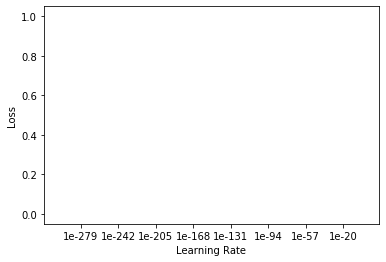

In [77]:
learn.recorder.plot()

In [78]:
learn.fit_one_cycle(5, 3e-4)

In [79]:
learn.save("stage-1c")

In [80]:
interp = learn.interpret()

In [81]:
interp.confusion_matrix()

array([[2013,    9,    0,    0],
       [   0, 2037,    0,    4],
       [   0,   10, 1924,    1],
       [   0,    2,    0, 1999]])

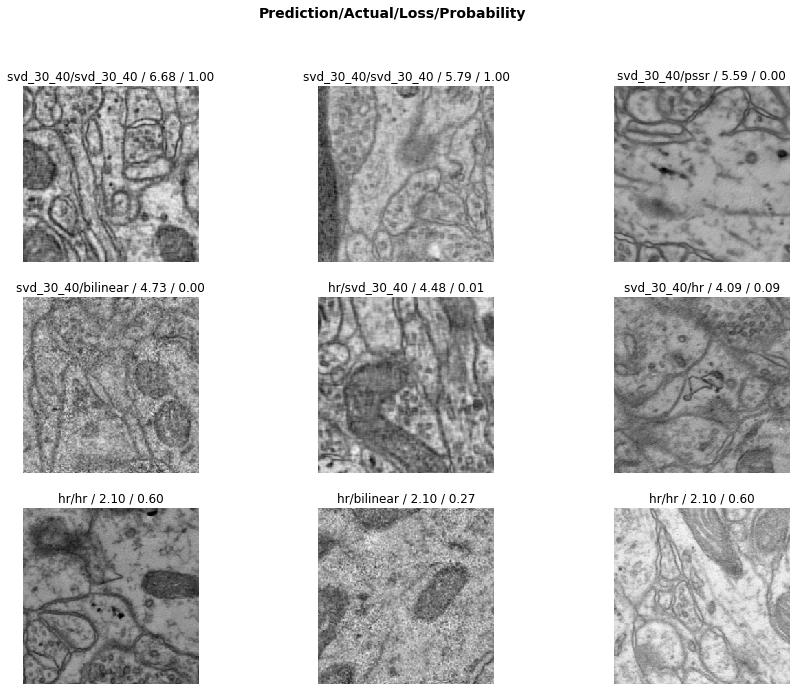

In [82]:
interp.plot_top_losses(9, figsize=(15,11))

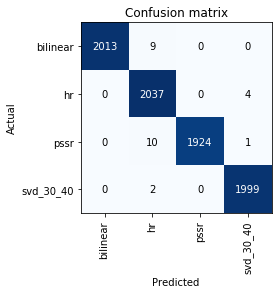

In [83]:
interp.plot_confusion_matrix()

## DEV Code

In [82]:
def subsample(data, pct=0.1):
    trn_size = len(data.train_ds)
    trn_indices = np.random.choice(np.arange(trn_size), 
                                   size=int(pct*trn_size), replace=False)
    trn_sampler = torch.utils.data.sampler.SubsetRandomSampler(trn_indices)
    val_size = len(data.valid_ds)
    val_indices = np.random.choice(np.arange(val_size), size=int(pct*val_size), replace=False)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
    data.train_dl = data.train_dl.new(shuffle=False, sampler=trn_sampler)
    data.valid_dl = data.valid_dl.new(shuffle=False, sampler=val_sampler)
    return data

In [85]:
mini_db = subsample(db)

In [86]:
mini_db

ImageDataBunch;

Train: LabelList (319991 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pssr,pssr,pssr,pssr,pssr
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets;

Valid: LabelList (79997 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bilinear,hr,svd_30_40,bilinear,pssr
Path: /home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets;

Test: None

In [89]:
len(mini_db.train_dl), len(mini_db.valid_dl)

(999, 250)

In [90]:
mini_db.stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

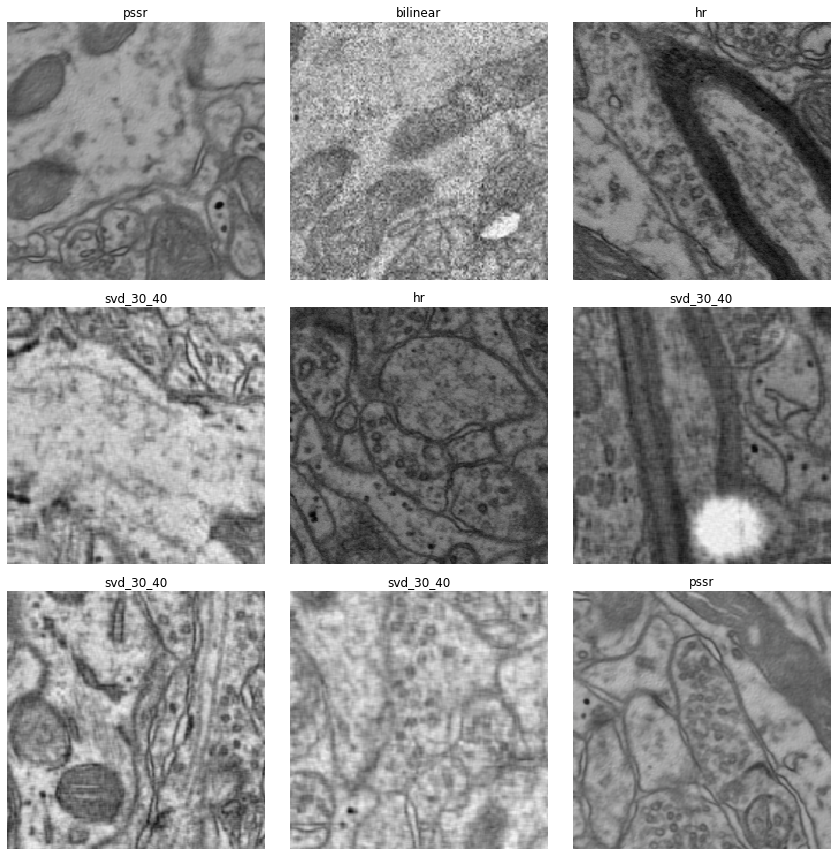

In [91]:
mini_db.show_batch(rows=3)